In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pd_support import read_df_csv
from scipy.interpolate import interp1d

In [ ]:
cart_df = pd.read_csv("..//data_csv//test.csv")

In [ ]:
# plt.plot(np.arange(len(cart_df["mils"])), cart_df["mils"].diff())
# plt.plot(np.arange(len(cart_df["mils"])), cart_df["mils"].diff())
cart_df["mils"].diff()

In [ ]:
mc, mc_dt = read_df_csv("..//data_csv//cart_random_mc.csv")
mc_dt

In [9]:
type(mc["org_x"][0])

numpy.float64

In [10]:
mc = mc.rename(columns={"time":"seconds"})

In [11]:
_t = []
for i in list(mc["seconds"]):
    _t.append(mc_dt + timedelta(0,float(i)))

mc["time"] = _t

In [12]:
mc

,frame,seconds,org_x,org_y,org_z,xdir_x,xdir_y,xdir_z,zdir_x,zdir_y,zdir_z,time
0,0,0.00,0.372066,0.062682,-0.089318,0.412840,0.061187,-0.088165,0.368545,0.062648,-0.025666,2022-06-15 17:41:53.371
1,1,0.01,0.372051,0.062662,-0.089333,0.412849,0.061191,-0.088166,0.368510,0.062674,-0.025655,2022-06-15 17:41:53.381
2,2,0.02,0.372070,0.062637,-0.089315,0.412834,0.061140,-0.088163,0.368532,0.062695,-0.025672,2022-06-15 17:41:53.391
3,3,0.03,0.372069,0.062652,-0.089324,0.412833,0.061156,-0.088165,0.368524,0.062681,-0.025673,2022-06-15 17:41:53.401
4,4,0.04,0.372066,0.062658,-0.089321,0.412827,0.061154,-0.088159,0.368526,0.062646,-0.025689,2022-06-15 17:41:53.411
...,...,...,...,...,...,...,...,...,...,...,...,...
6314,6314,63.14,0.037280,0.068873,-0.085428,0.077838,0.067106,-0.087170,0.038145,0.068804,-0.021561,2022-06-15 17:42:56.511
6315,6315,63.15,0.037297,0.068825,-0.085467,0.077832,0.067124,-0.087163,0.038147,0.068819,-0.021562,2022-06-15 17:42:56.521
6316,6316,63.16,0.037267,0.068837,-0.085447,0.077830,0.067113,-0.087170,0.038138,0.068835,-0.021552,2022-06-15 17:42:56.531
6317,6317,63.17,0.037304,0.068842,-0.085422,0.077817,0.067092,-0.087173,0.038125,0.068796,-0.021542,2022-06-15 17:42:56.541


In [13]:
mc["time"] = pd.to_datetime(mc["time"])

In [14]:
"""getting initial values of motion capture data"""

# marker_cen = np.array(mc[["center_x", "center_y", "center_z"]].iloc[0]).T
marker_xvec = np.array(mc[["xdir_x", "xdir_y", "xdir_z"]].iloc[0]).T
marker_zvec = np.array(mc[["zdir_x", "zdir_y", "zdir_z"]].iloc[0]).T
marker_org = np.array(mc[["org_x", "org_y", "org_z"]].iloc[0]).T
marker_org[0]

0.372066

In [15]:
v1 = marker_xvec - marker_org #v1
v2 = marker_zvec - marker_org #v2

v1 = v1.reshape(3,1)
v2 = v2.reshape(3,1)
v3 = marker_org.reshape(3,1)

In [16]:
def calculate_rotmat(xdir,zdir,org):
    """
    this function calculates rotation matrix
    """
    v1 = xdir - org #v1
    v2 = zdir - org #v2

    vxnorm = v1/np.linalg.norm(v1)

    vzcap = v2 - (vxnorm.T @ v2) * vxnorm
    vznorm = vzcap/ np.linalg.norm(vzcap)

    vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3,1)
    rotMat = np.hstack((vxnorm, vynorm, vznorm))
    return rotMat

In [17]:
"""getting initial rot mat in mc data"""

rot_mat = calculate_rotmat(v1, v2, v3)
rot_mat

array([[-0.94826055,  0.23644182,  0.21188957],
       [-0.1836945 , -0.95291786,  0.24125483],
       [ 0.25895609,  0.18984949,  0.94704747]])

In [18]:
temp_list = []
for i in range(len(mc["xdir_x"])):
    # center_val =  np.array(mc[["center_x", "center_y", "center_z"]].iloc[i])
    center_val =  np.array(mc[["org_x", "org_y", "org_z"]].iloc[i])

    center_val = center_val.reshape(3,1)
    transformed_center = rot_mat.T @ (center_val - v3)
    # if i == 0:
    #     print(center_val - v3)
    transformed_center = transformed_center.T[0]
    temp_list.append(transformed_center)
mc[["cen_x", "cen_y", "cen_z"]] = temp_list

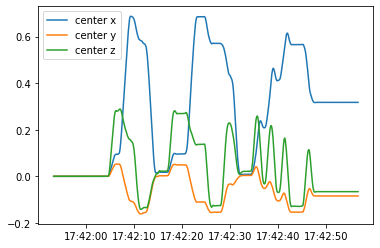

In [19]:
plt.plot(mc["time"], mc["cen_x"], label="center x")
plt.plot(mc["time"], mc["cen_y"], label="center y")
plt.plot(mc["time"], mc["cen_z"], label="center z")
plt.legend()

In [20]:
"""resetting cart values to zero"""
cart_df["e_fr"] = cart_df["e_fr"]- cart_df["e_fr"].iloc[0]
cart_df["e_fl"] = cart_df["e_fl"]- cart_df["e_fl"].iloc[0]
cart_df["e_rr"] = cart_df["e_rr"]- cart_df["e_rr"].iloc[0]
cart_df["e_rl"] = cart_df["e_rl"]- cart_df["e_rl"].iloc[0]

cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl
0,2022-06-15 17:41:42.658968,0,0,0,0
1,2022-06-15 17:41:42.851436,0,0,0,0
2,2022-06-15 17:41:42.851436,0,0,0,0
3,2022-06-15 17:41:42.851936,0,0,0,0
4,2022-06-15 17:41:42.851936,0,0,0,0
...,...,...,...,...,...
8508,2022-06-15 17:42:59.441218,-4576,4122,2725,-5178
8509,2022-06-15 17:42:59.441218,-4576,4122,2725,-5178
8510,2022-06-15 17:42:59.441675,-4576,4122,2725,-5178
8511,2022-06-15 17:42:59.441675,-4576,4122,2725,-5178


In [21]:
mils = np.arange(0, len(cart_df["e_fr"])*10, 10)
cart_df["mils"] = mils
cart_df["sys_time"] = pd.to_datetime(cart_df["sys_time"])

These are the parameters of the cart

Diameter = 95 mm
radius = 47.5
wheel thickness = 45 mm
gap between wheel and chassis = 6.5 mm
angle between center of chassis and z-dir vector = 51.21 degrees
distance between the wheel = 158 mm
distance between the wheel and the center of the robot = 101.36 (li)


In [22]:
"""circumfrence of the wheel"""

cir_wheel = np.degrees(2*np.pi*(47.5/1000))
cir_wheel
radius = 47.5/1000

lx = 79 #half of the distance between the wheels
ly = 122.5/2

lx = lx/1000
ly = ly/1000

The encoder values will give 4000 values per revolution
360/4000 = 0.09 degrees per encoder rotation value

In [23]:
""" angular velocity"""
cart_df["av_fr"] = (cart_df["e_fr"]*0.09).diff()/0.01
cart_df["av_fl"] = (cart_df["e_fl"]*0.09).diff()/0.01
cart_df["av_rr"] = (cart_df["e_rr"]*0.09).diff()/0.01
cart_df["av_rl"] = (cart_df["e_rl"]*0.09).diff()/0.01
cart_df['av_fr'] = cart_df["av_fr"].fillna(0)
cart_df['av_fl'] = cart_df["av_fl"].fillna(0)
cart_df['av_rr'] = cart_df["av_rr"].fillna(0)
cart_df['av_rl'] = cart_df["av_rl"].fillna(0)

#converting them to radians
cart_df['av_fr'] = cart_df["av_fr"]* np.pi/180
cart_df['av_fl'] = cart_df["av_fl"]* np.pi/180
cart_df['av_rr'] = cart_df["av_rr"]* np.pi/180
cart_df['av_rl'] = cart_df["av_rl"]* np.pi/180

cart_df["av_fl"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8508    0.0
8509    0.0
8510    0.0
8511    0.0
8512    0.0
Name: av_fl, Length: 8513, dtype: float64

In [24]:
# g1 = np.radians(-51.21)
# g2 = np.radians(51.21)

g1 = np.radians(-np.pi/2)
g2 = np.radians(np.pi/2)

g3 = g2
g4 = g1


b1 = np.pi/4
b2 = -np.pi/4
b3 = b1
b4 = b2


a1 = np.pi/4
a2 = -np.pi/4
a3 = 3*np.pi/4
a4 = -3*np.pi/4


li = 101.36/1000

In [25]:
t = (-1/radius)*np.array([[np.cos(b1 - g1)/ np.sin(g1), np.sin(b1 - g1)/np.sin(g1), li * np.sin(b1 - g1 - a1)/np.sin(g1)],
                         [np.cos(b2 - g2)/ np.sin(g2), np.sin(b2 - g2)/np.sin(g2), li * np.sin(b2 - g2 - a2)/np.sin(g2)],
                         [np.cos(b3 - g3)/ np.sin(g3), np.sin(b3 - g3)/np.sin(g3), li * np.sin(b3 - g3 - a3)/np.sin(g3)],
                         [np.cos(b4 - g4)/ np.sin(g4), np.sin(b4 - g4)/np.sin(g4), li * np.sin(b4 - g4 - a4)/np.sin(g4)]]
                         )
t
pseudo_t = np.linalg.pinv(t)
pseudo_t

array([[ 4.47561242e-04, -4.47561242e-04, -4.72799786e-04,
         4.72799786e-04],
       [ 8.73787444e-04,  8.73787444e-04, -2.39613824e-05,
        -2.39613824e-05],
       [ 5.92854944e-03,  5.92854944e-03,  6.26286783e-03,
         6.26286783e-03]])

In [26]:
val = pseudo_t @ np.array([[cart_df["av_fr"][0]],[cart_df["av_fl"][0]], [cart_df["av_rr"][0]], [cart_df["av_rl"][0]]])
val.T

array([[0., 0., 0.]])

In [27]:
np.array([[cart_df["av_fr"][0]],[cart_df["av_fl"][0]], [cart_df["av_rr"][0]], [cart_df["av_rl"][0]]])

array([[0.],
       [0.],
       [0.],
       [0.]])

In [28]:
_val = []
for i in range(len(cart_df["e_fl"])):
    _v = pseudo_t @ np.array([[cart_df["av_fr"][i]],[cart_df["av_fl"][i]], [cart_df["av_rr"][i]], [cart_df["av_rl"][i]]])
    _val.append(_v.T[0])

cart_df[["cal_vx", "cal_vy", "cal_w"]] = _val
# _val

In [29]:
"""finding vx, vy, w"""

cart_df["vx"] = (cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] + cart_df["av_rr"])*(radius/4)
cart_df["vy"] = (- cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] - cart_df["av_rr"])*(radius/4)
cart_df["w"] = (- cart_df["av_fl"] + cart_df["av_fr"] - cart_df["av_rl"] + cart_df["av_rr"])*(radius/(4*(lx + ly)))

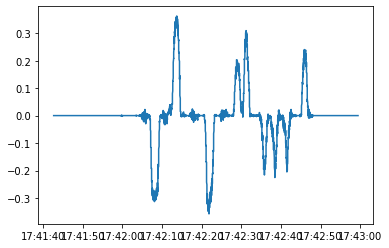

In [30]:
plt.plot(cart_df["sys_time"], cart_df["vy"])
# plt.plot(cart_df["vx"])

In [31]:
"""calculating displacement
s=(1/2)* (v+u)t
v = current velocityn
u = initial velocity
t = time
s = displacement
"""

_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["vx"].iloc[i] + cart_df["vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["vy"].iloc[i] + cart_df["vy"].iloc[i-1])*0.01
        print(y_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+y_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["x_val"] = _xval
cart_df["y_val"] = _yval
# cart_df["y_val"]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [32]:
"""calculating displacement for calculated coordinates

"""
_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["cal_vx"].iloc[i] + cart_df["cal_vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["cal_vy"].iloc[i] + cart_df["cal_vy"].iloc[i-1])*0.01
        # print(x_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+y_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["cal_x"] = _xval
cart_df["cal_y"] = _yval


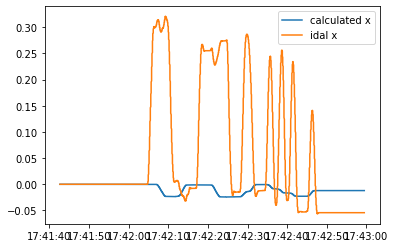

In [33]:
# plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "ideal x")
plt.plot(cart_df["sys_time"],cart_df["cal_x"], label = "calculated x")
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "idal x")
plt.legend()

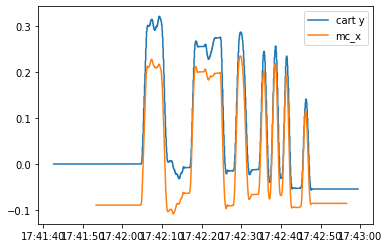

In [34]:
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "cart y")
plt.plot(mc["time"], mc["org_z"], label  = "mc_x")
plt.legend()

In [35]:
_t2 = []
for i in cart_df["sys_time"]:
    _tt = mc["time"][0]-i
    # print(_tt)
    _t2.append(_tt.total_seconds())


-0.372066


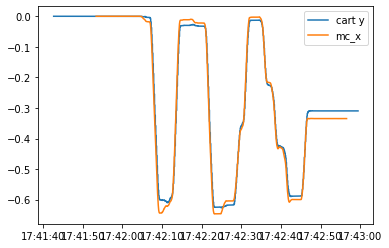

In [36]:
offset = cart_df["y_val"].iloc[0] - mc["org_x"].iloc[0]
plt.plot(cart_df["sys_time"], cart_df["y_val"], label = "cart y")
plt.plot(mc["time"], mc["org_x"] +offset, label  = "mc_x")
plt.savefig("lateral.png")
plt.legend()
print(offset)

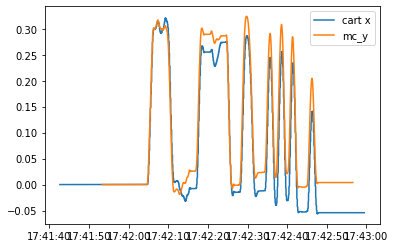

In [37]:
offset = cart_df["x_val"].iloc[0] - mc["org_z"].iloc[0]
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "cart x")
plt.plot(mc["time"], mc["org_z"] +offset, label  = "mc_y")


plt.legend()
plt.savefig("transversal.png")

In [38]:
# print (cart_df["sys_time"].get_loc(mc["time"][0], method='nearest'))
print(cart_df["sys_time"][0])
print(mc["time"][0])

result_index = cart_df['sys_time'].sub(mc["time"][0]).abs().idxmin()

cart_df.iloc[(cart_df['sys_time'] - mc["time"][0]).abs().argsort()[0],:]
# (cart_df['sys_time'] - mc["time"][0]).abs()
result_index

2022-06-15 17:41:42.658968
2022-06-15 17:41:53.371000


1274

In [39]:
# cart_df["diff"] = cart_df["y_val"]- cart_df["center_x"] - 0.34

In [40]:
rw = []
vr = []
for i in range(len(cart_df["av_rl"])):
    _vy = cart_df["cal_vy"][i]
    _vx = cart_df["cal_vx"][i]
    rw.append(np.arctan2(_vy, _vx))
    vr.append(np.linalg.norm((_vx, _vy)))
cart_df["rw"] = rw
cart_df["vr"] = vr

In [41]:
cart_df["rw"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8508    0.0
8509    0.0
8510    0.0
8511    0.0
8512    0.0
Name: rw, Length: 8513, dtype: float64

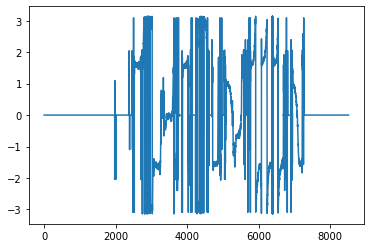

In [42]:
plt.plot(cart_df["rw"])

In [43]:
cart_df["rw"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8508    0.0
8509    0.0
8510    0.0
8511    0.0
8512    0.0
Name: rw, Length: 8513, dtype: float64